In [1]:
import mxnet as mx

from mxboard import SummaryWriter
from mxnet import Context, cpu, gpu
from mxnet.ndarray import concat, clip
from tqdm import tqdm
 
from discriminator import Discriminator
from generator_vgg import Generator

from util import Device
import matplotlib.pyplot as plt 
import numpy as np
from mxnet.io import NDArrayIter
import os

import generator_vgg as gen
import discriminator as dis
import time
from glob import glob
from mxnet.ndarray import stack
import mxnet.gluon
import modules

import matplotlib.pyplot as plt

In [3]:
sub_id = '18'
case = '1'
roi = 'VIS'

runname = f'sub18_VIS_Case{case}_{int(time.time())}'

device       = Device.GPU2
epochs       = 4000
features     = 64 # ??
batch_size = 8
all_image_size = 96 ## ??
in_chan = 5

In [4]:
if __name__=='__main__':
    
    context = cpu() if device.value == -1 else gpu(device.value)
    
    summaryWriter = SummaryWriter('logs/' + runname, flush_secs = 5)
    
    train_iter = modules.make_iterator_preprocessed('training', sub_id, roi, case, batch_size=batch_size, shuffle=True) # shuffle=True
    test_iter = modules.make_iterator_preprocessed('testing', sub_id, roi, case, batch_size=batch_size, shuffle=True) # shuffle=True

    RFlocs_VIS_overlapped_avg = modules.get_RFs(sub_id, roi, context)
    
    with Context(context):
        discriminator = Discriminator(in_chan)
        generator = Generator(in_chan, context)
        gen_lossfun = gen.Lossfun(1, 100, 1, context)
        d = discriminator.network

        dis_lossfun = dis.Lossfun(1)
        g = generator.network

        for epoch in range(epochs):

            
            loss_discriminator_train = []
            loss_generator_train = []

            # ====================
            # T R AI N I N G
            # ====================

            for RFsignalsVIS, targets in tqdm(train_iter, total = len(train_iter)):
                # -------
                # Inputs
                # -------
                inputs_train = modules.get_inputsROI(RFsignalsVIS, RFlocs_VIS_overlapped_avg, context)
                # ------------------------------------
                # T R A I N  D i s c r i m i n a t o r
                # ------------------------------------
                targets_train = targets.as_in_context(context)

                loss_discriminator_train.append(discriminator.train(g, inputs_train, targets_train))

                # ----------------------------
                # T R A I N  G e n e r a t o r
                # ----------------------------
                loss_generator_train.append(generator.train(d, inputs_train, targets_train))
            
#             os.makedirs('saved_models/'+runname, exist_ok=True)
#             generator.network.save_parameters(f'saved_models/{runname}/netG_{epoch}.model')
#             discriminator.network.save_parameters(f'saved_models/{runname}/netD_{epoch}.model')
            os.makedirs('saved_models/'+runname, exist_ok=True)
            generator.network.save_parameters(f'saved_models/{runname}/netG_final.model')
            discriminator.network.save_parameters(f'saved_models/{runname}/netD_final.model')
        
            summaryWriter.add_image("input_train", modules.leclip(inputs_train.expand_dims(2).sum(1)), epoch)
            summaryWriter.add_image("target_train", modules.leclip(targets_train), epoch)
            summaryWriter.add_image("pred_train", modules.leclip(g(inputs_train)), epoch)
            
            summaryWriter.add_scalar("dis/loss_discriminator_train", sum(loss_discriminator_train) / len(loss_discriminator_train), epoch)
            summaryWriter.add_scalar("gen/loss_generator_train", sum(loss_generator_train) / len(loss_generator_train), epoch)


            # ====================
            # T E S T I N G 
            # ====================
            loss_discriminator_test = []
            loss_generator_test = []

            for RFsignalsVIS, targets in test_iter:
                # -------
                # Inputs
                # -------
                inputs_test = modules.get_inputsROI(RFsignalsVIS, RFlocs_VIS_overlapped_avg, context)
                
                # -----
                # Targets
                # -----            
                targets_test = targets.as_in_context(context)

                # ----
                # sample randomly from history buffer (capacity 50) 
                # ----

                z = concat(inputs_test, g(inputs_test), dim=1)

                dis_loss_test = 0.5 * (dis_lossfun(0, d(z)) + dis_lossfun(1,d(concat(inputs_test, targets_test, dim=1))))

                loss_discriminator_test.append(float(dis_loss_test.asscalar()))

                gen_loss_test = (lambda y_hat: gen_lossfun(1, d(concat(inputs_test, y_hat, dim=1)), targets_test, y_hat))(generator.network(inputs_test))

                loss_generator_test.append(float(gen_loss_test.asscalar()))

            summaryWriter.add_image("input_test", modules.leclip(inputs_test.expand_dims(2).sum(1)), epoch)
            summaryWriter.add_image("target_test", modules.leclip(targets_test), epoch)
            summaryWriter.add_image("pred_test", modules.leclip(g(inputs_test)), epoch)
            
            summaryWriter.add_scalar("dis/loss_discriminator_test", sum(loss_discriminator_test) / len(loss_discriminator_test), epoch)
            summaryWriter.add_scalar("gen/loss_generator_test", sum(loss_generator_test) / len(loss_generator_test), epoch)

            # ------------------------------------------------------------------
            # T R A I N I N G Losses
            # ------------------------------------------------------------------
            np.save(f'saved_models/{runname}/Gloss_train', np.array(loss_generator_train))
            np.save(f'saved_models/{runname}/Dloss_train', np.array(loss_discriminator_train))
            # ------------------------------------------------------------------
            # T E S T I N G Losses
            # ------------------------------------------------------------------
            np.save(f'saved_models/{runname}/Gloss_test', np.array(loss_generator_test))
            np.save(f'saved_models/{runname}/Dloss_test', np.array(loss_discriminator_test))

100%|██████████| 400/400 [01:04<00:00,  6.23it/s]


In [ ]:
# plt.plot(loss_discriminator_train)

In [24]:
# plt.plot(loss_generator_train)

In [8]:
# inputs_np = inputs.asnumpy()
# targets_np = targets.asnumpy()
# output_np = g(inputs).asnumpy()

In [9]:
# inputs_np.shape, targets_np.shape, output_np.shape

((8, 5, 96, 96), (8, 3, 96, 96), (8, 3, 96, 96))

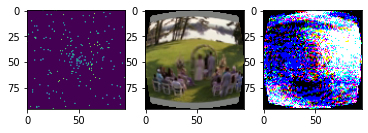

In [13]:
# ex = 5
# plt.subplot(1,3,1)
# plt.imshow(inputs_np[ex].sum(0))
# plt.subplot(1,3,2)
# plt.imshow(targets_np[ex].transpose(1,2,0))
# plt.subplot(1,3,3)
# plt.imshow(output_np[ex].transpose(1,2,0))
# plt.show()

In [27]:
# g(in)

Network(
  (0): Conv2D(5 -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(0.2)
  (2): Skip(
    (_block): HybridSequential(
      (0): Conv2D(64 -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm(axis=1, eps=1e-05, momentum=0.1, fix_gamma=False, use_global_stats=False, in_channels=128)
      (2): LeakyReLU(0.2)
      (3): Skip(
        (_block): HybridSequential(
          (0): Conv2D(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.1, fix_gamma=False, use_global_stats=False, in_channels=256)
          (2): LeakyReLU(0.2)
          (3): Skip(
            (_block): HybridSequential(
              (0): Conv2D(256 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm(axis=1, eps=1e-05, momentum=0.1, fix_gamma=False, use_global_stats=False, in_channels=512)
              (2): LeakyReLU(0.2)
        